### 機器學習：分類 Classification

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import pickle

pd.set_option('display.max_columns', None)

### 讀入 Dataset

In [2]:
col_to_pick = ['airline',
               'airport_depa',
               'airport_dest',
            #    'month_actu_depa',
               'day_actu_depa',
               'hr_actu_depa',
               'min_actu_depa',
            #    'month_actu_dest',
               'day_actu_dest',
               'hr_actu_dest',
               'min_actu_dest',
               'actu_duration',
               'dry_bulb_temp_dest',
            #    'wet_bulb_temp_dest',
            #    'dew_point_temp_dest',
               'precipitation_dest',
               'snow_fall_dest',
            #    'snow_depth_dest',
               'relative_humidity_dest',
               'wind_speed_dest',
               'pressure_dest',
               'visibility_dest',
               'delay_dest']

In [3]:
df = pd.read_csv('../data/US_1722_flights_dataset_v1_IQR_ML.csv', usecols=col_to_pick)
df.shape

(28926859, 18)

### 欄位編碼、處理

In [4]:
# 對 delay_dest_01 進行分類編碼(0, 1)
df['delay_dest_01'] = np.where((df['delay_dest'] > 15), 1, 0)

In [6]:
# # 挑選流量前 20 大的機場，進行頻率編碼
# airport_to_pick = ['ALT', 'ORD', 'DFW', 'DEN', 'LAX', 'CLI', 'PHX', 'SEA', 'LAS', 'IAN', 'SFO', 'MSP', 'MCO', 'DTW', 'SLC', 'BOS', 'LGA', 'EWR', 'DCA', 'JFK']
# df = df[(df['airport_depa'].isin(airport_to_pick)) & (df['airport_dest'].isin(airport_to_pick))]

# 進行頻率編碼
freq = df['airline'].value_counts(normalize=True)
df['airline_freq'] = df['airline'].map(freq)
freq = df['airport_depa'].value_counts(normalize=True)
df['airport_depa_freq'] = df['airport_depa'].map(freq)
freq = df['airport_dest'].value_counts(normalize=True)
df['airport_dest_freq'] = df['airport_dest'].map(freq)

# 分鐘數轉整數
df['actu_duration'] = df['actu_duration'].astype(int)

# 壓力轉小數點後2位
df['pressure_dest'] = df['pressure_dest'].round(2)

# 風速轉整數
df['wind_speed_dest'] = df['wind_speed_dest'].astype(int)

# 能見度轉整數
df['visibility_dest'] = df['visibility_dest'].astype(int)

df

,airline,airport_depa,airport_dest,day_actu_depa,hr_actu_depa,min_actu_depa,day_actu_dest,hr_actu_dest,min_actu_dest,actu_duration,delay_dest,dry_bulb_temp_dest,precipitation_dest,snow_fall_dest,relative_humidity_dest,wind_speed_dest,pressure_dest,visibility_dest,delay_dest_01,airline_freq,airport_depa_freq,airport_dest_freq
0,DL,ABE,ATL,9,6,1,9,7,59,118,-17.0,30.0,0.000,0.0,49.00,17,29.56,10,0,0.146814,0.000607,0.057873
1,DL,ABE,ATL,10,5,57,10,8,16,139,0.0,33.0,0.000,0.0,64.00,20,29.37,10,0,0.146814,0.000607,0.057873
2,DL,ABE,ATL,11,5,57,11,8,6,129,-10.0,56.0,0.000,0.0,70.00,23,29.22,10,0,0.146814,0.000607,0.057873
3,DL,ABE,ATL,12,5,57,12,7,56,119,-20.0,54.0,0.000,0.0,83.00,23,29.25,10,0,0.146814,0.000607,0.057873
4,DL,ABE,ATL,13,5,54,13,7,54,120,-22.0,59.0,0.000,0.0,93.00,23,29.37,10,0,0.146814,0.000607,0.057873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28926854,YV,YUM,PHX,27,19,7,27,20,7,60,-7.0,65.0,0.000,0.0,39.00,17,28.68,10,0,0.021004,0.000273,0.025462
28926855,YV,YUM,PHX,28,11,50,28,12,49,59,14.0,53.5,0.015,0.0,92.25,17,28.69,3,0,0.021004,0.000273,0.025462
28926856,YV,YUM,PHX,29,11,39,29,12,25,46,-10.0,60.0,0.000,0.0,60.00,17,28.77,10,0,0.021004,0.000273,0.025462
28926857,YV,YUM,PHX,30,11,40,30,12,44,64,9.0,56.0,0.020,0.0,85.50,17,28.89,6,0,0.021004,0.000273,0.025462


In [7]:
# 取得頻率編碼表
df_airline = df[['airline', 'airline_freq']]
df_airline = df_airline.drop_duplicates(subset=['airline_freq'], keep='first')
df_airline = df_airline.sort_values(by='airline_freq').reset_index(drop=True)
airline_freq = {k:v for k, v in zip(df_airline.iloc[:, 0], df_airline.iloc[:, 1])}

df_airport_depa = df[['airport_depa', 'airport_depa_freq']]
df_airport_depa = df_airport_depa.drop_duplicates(subset=['airport_depa_freq'], keep='first')
df_airport_depa = df_airport_depa.sort_values(by='airport_depa_freq').reset_index(drop=True)
airport_depa_freq = {k:v for k, v in zip(df_airport_depa.iloc[:, 0], df_airport_depa.iloc[:, 1])}

df_airport_dest = df[['airport_dest', 'airport_dest_freq']]
df_airport_dest = df_airport_dest.drop_duplicates(subset=['airport_dest_freq'], keep='first')
df_airport_dest = df_airport_dest.sort_values(by='airport_dest_freq').reset_index(drop=True)
airport_dest_freq = {k:v for k, v in zip(df_airport_dest.iloc[:, 0], df_airport_dest.iloc[:, 1])}

# # 將字典轉換為JSON格式並保存到文件中
# with open('../json/airline_freq.json', 'w') as i:
#     json.dump(airline_freq, i)
# with open('../json/airport_depa_freq.json', 'w') as j:
#     json.dump(airport_depa_freq, j)
# with open('../json/airport_dest_freq.json', 'w') as k:
#     json.dump(airport_dest_freq, k)

### 欄位切割

In [8]:
# 計算 delay 的資料量
df['delay_dest_01'].value_counts()

0    27499413
1     1427446
Name: delay_dest_01, dtype: int64

將有 delay 的資料切割出來

In [9]:
# 切割 delay 資料
df_delay = df[df['delay_dest'] > 15]
df_delay.shape

(1427446, 22)

In [10]:
# 切割 未delay 資料
df_ontime = df[df['delay_dest'] <= 15]
df_ontime.shape

(27499413, 22)

In [11]:
# 亂數取 未 delay 的 index
random_index = np.random.randint(low=0 ,high=len(df_ontime), size=len(df_delay))
random_index = random_index.tolist()

# 建立以亂數篩選後筆數與 delay 資料相同的 未delay 資料
df_ontime_random = df_ontime.iloc[random_index, :]
df_ontime_random.shape

(1427446, 22)

In [12]:
# 合併資料量相同的 delay 與 未delay 資料
df_ML = pd.concat([df_ontime_random, df_delay], axis=0, ignore_index=True)
df_ML.shape

(2854892, 22)

In [13]:
# 計算 經篩選後delay 的資料量
df_ML['delay_dest_01'].value_counts()

0    1427446
1    1427446
Name: delay_dest_01, dtype: int64

### 設定 X, y

In [14]:
# 設定 X, y
y = df_ML['delay_dest_01']
cols = ['airline_freq',
        'airport_depa_freq',
        'airport_dest_freq',
        # 'month_actu_depa',
        'day_actu_depa',
        'hr_actu_depa',
        'min_actu_depa',
        # 'month_actu_dest',
        'day_actu_dest',
        'hr_actu_dest',
        'min_actu_dest',
        'actu_duration',
        'dry_bulb_temp_dest',
        # 'wet_bulb_temp_dest',
        # 'dew_point_temp_dest',
        'precipitation_dest',
        'snow_fall_dest',
        # 'snow_depth_dest',
        'relative_humidity_dest',
        'wind_speed_dest',
        'pressure_dest',
        'visibility_dest'
        ]
X = df_ML[cols]

In [15]:
X

,airline_freq,airport_depa_freq,airport_dest_freq,day_actu_depa,hr_actu_depa,min_actu_depa,day_actu_dest,hr_actu_dest,min_actu_dest,actu_duration,dry_bulb_temp_dest,precipitation_dest,snow_fall_dest,relative_humidity_dest,wind_speed_dest,pressure_dest,visibility_dest
0,0.146814,0.005114,0.057873,19,12,10,19,15,22,132,75.0,0.0,0.00,54.0,21,29.15,10
1,0.114994,0.000717,0.041695,11,5,29,11,6,30,61,27.0,0.0,0.10,61.0,22,29.70,9
2,0.087126,0.025429,0.021736,18,13,16,18,14,12,116,89.0,0.0,0.00,31.0,30,29.69,10
3,0.114994,0.025606,0.001158,22,15,13,22,16,41,88,47.0,0.0,0.00,65.0,22,28.66,9
4,0.039886,0.029652,0.006149,5,13,1,5,14,28,87,36.0,0.0,0.05,39.0,30,28.81,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854887,0.021004,0.000273,0.025462,16,5,35,16,6,44,69,58.0,0.0,0.00,29.0,25,28.69,10
2854888,0.021004,0.000273,0.025462,17,9,2,17,10,13,71,70.0,0.0,0.00,20.0,20,28.86,10
2854889,0.021004,0.000273,0.025462,15,13,29,15,14,56,87,87.0,0.0,0.00,7.0,17,28.65,10
2854890,0.021004,0.000273,0.025462,16,13,59,16,14,51,52,89.0,0.0,0.00,6.0,23,28.70,10


### 熱力圖

In [16]:
# heatmap_cols = ['delay_dest_01',
#                 'airline_freq',
#                 'airport_depa_freq',
#                 'airport_dest_freq',
#                 # 'month_actu_depa',
#                 # 'day_actu_depa',
#                 # 'hr_actu_depa',
#                 # 'min_actu_depa',
#                 # 'month_actu_dest',
#                 # 'day_actu_dest',
#                 # 'hr_actu_dest',
#                 # 'min_actu_dest',
#                 # 'sche_duration',
#                 # 'dry_bulb_temp_dest',
#                 # 'wet_bulb_temp_dest',
#                 # 'dew_point_temp_dest',
#                 # 'precipitation_dest',
#                 # 'snow_fall_dest',
#                 # 'snow_depth_dest',
#                 # 'relative_humidity_dest',
#                 # 'wind_speed_dest',
#                 # 'pressure_dest',
#                 # 'visibility_dest'
#                 ]

In [17]:
# import seaborn as sns

# # 建立新繪圖區、設定畫布大小
# plt.figure(figsize=(15, 15))

# # 繪製熱力圖
# sns.heatmap(df_ML[heatmap_cols].corr(),
#             annot=True,
#             fmt=".3f",
#             linewidth=.5,
#             cmap="RdBu",
#             center=0,
#             square=True)

# # 標題
# plt.title('heatmap')

# # 顯示圖表
# plt.show()

### XGboost

[0]	validation_0-logloss:0.68711	validation_1-logloss:0.68713
[1]	validation_0-logloss:0.68164	validation_1-logloss:0.68170
[2]	validation_0-logloss:0.67670	validation_1-logloss:0.67679
[3]	validation_0-logloss:0.67213	validation_1-logloss:0.67224
[4]	validation_0-logloss:0.66788	validation_1-logloss:0.66802
[5]	validation_0-logloss:0.66401	validation_1-logloss:0.66418
[6]	validation_0-logloss:0.66048	validation_1-logloss:0.66067
[7]	validation_0-logloss:0.65703	validation_1-logloss:0.65725
[8]	validation_0-logloss:0.65386	validation_1-logloss:0.65410
[9]	validation_0-logloss:0.65096	validation_1-logloss:0.65122
[10]	validation_0-logloss:0.64832	validation_1-logloss:0.64861
[11]	validation_0-logloss:0.64574	validation_1-logloss:0.64606
[12]	validation_0-logloss:0.64345	validation_1-logloss:0.64379
[13]	validation_0-logloss:0.64114	validation_1-logloss:0.64151
[14]	validation_0-logloss:0.63910	validation_1-logloss:0.63948
[15]	validation_0-logloss:0.63722	validation_1-logloss:0.63764
[1

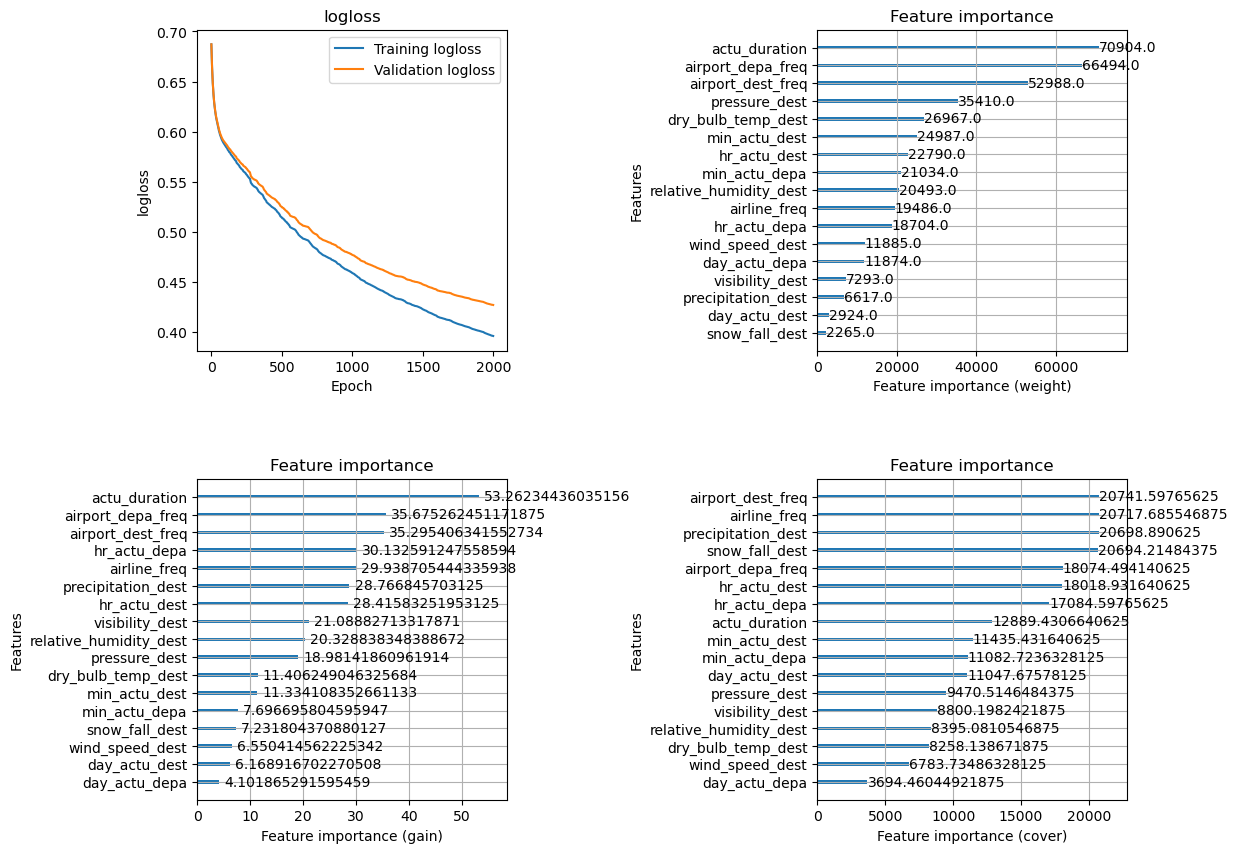

In [18]:
# 切割 train, test, validation 資料
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=36)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=76)


# # 標準化
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)


# 設定 XGBoost 參數
params = {
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'max_depth': 8,             # 'max_depth' & 'max_leaves'擇一
    # 'max_leaves': 30,            # 'max_depth' & 'max_leaves'擇一
    # 'reg_alpha': 0.3,             # 取值在 0 到 1 之間
    # 'reg_lambda': 0.3,            # 取值在 0 到 1 之間
    'random_state': 66,
    'early_stopping_rounds': 10,
    'eval_metric': 'logloss'      # 評估指標：'logloss'（對數損失）、'auc'（曲線下面積）、'error'（分類錯誤率）
}


# 訓練模型並紀錄損失
classifier = xgb.XGBClassifier(**params)
eval_set = [(X_train, y_train), (X_val, y_val)]
classifier.fit(X_train, y_train, eval_set=eval_set, verbose=True)
train_loss = classifier.evals_result()['validation_0']['logloss']
val_loss = classifier.evals_result()['validation_1']['logloss']


# 預測結果
y_test_pred = classifier.predict(X_test)
# 衡量模型指標
accuracy = accuracy_score(y_test, y_test_pred)
cm =confusion_matrix(y_test, y_test_pred)
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{cm}')


# 繪製損失曲線圖表、特徵重要性圖表'weight'、'gain'和'cover'
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
# 繪製損失曲線圖表
ax[0, 0].plot(train_loss, label='Training logloss')
ax[0, 0].plot(val_loss, label='Validation logloss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('logloss')
ax[0, 0].set_title('logloss')
ax[0, 0].legend()
# 繪製特徵重要性圖表
xgb.plot_importance(classifier, ax=ax[0, 1], xlabel='Feature importance (weight)', importance_type='weight')
xgb.plot_importance(classifier, ax=ax[1, 0], xlabel='Feature importance (gain)', importance_type='gain')
xgb.plot_importance(classifier, ax=ax[1, 1], xlabel='Feature importance (cover)', importance_type='cover')
# 調整子圖之間的間距
plt.subplots_adjust(wspace=1, hspace=0.4)
plt.show()

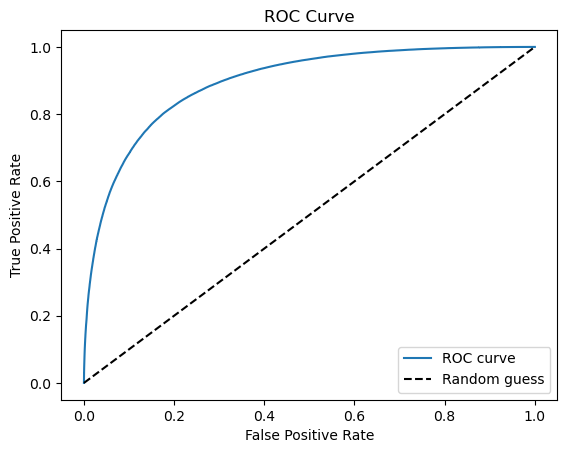

AUC: 0.89


In [19]:
# 預測測試集樣本的概率
y_proba = classifier.predict_proba(X_test)[:, 1]

# 計算FPR、TPR和閾值
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 繪製ROC曲線
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 計算AUC
auc = roc_auc_score(y_test, y_proba)
print('AUC: %.2f' % auc)

In [20]:
# 0為未delay、1為delay
# 輸出模型準確率、召回率、F1score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    214078
           1       0.81      0.82      0.81    214156

    accuracy                           0.81    428234
   macro avg       0.81      0.81      0.81    428234
weighted avg       0.81      0.81      0.81    428234



### 儲存模型

In [22]:
# pickle.dump(classifier, open("../model/xgb_classfier_0425.pkl", "wb"))